In [1]:
import Target_cohesin_loading.utils as utils #for calculations
import matplotlib.pylab as plt
import numpy as np
import sys
import glob
import h5py 
import cooltools
import cooltools.lib.plotting
import pandas as pd
import time
import seaborn as sns
import warnings
import ast

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/cooltools/lib/numutils.py:11: FutureWarning: The `cooler.tools` module is deprecated in v0.9 and will be removed in v0.10. Use `cooler.parallel` instead.
  from ._numutils import (
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/cooltools/api/expected.py:14: FutureWarning: The `cooler.tools` module is deprecated in v0.9 and will be removed in v0.10. Use `cooler.parallel` instead.
  from cooler.tools import partition


#### Parameters

In [2]:
LatticeCoversion = 0.25 #Each lattice site is representing in base pairs 0.25 kb 
site = 10 #number of sites per monomer
ReferenceLoad = 0.0001 #We plot according to the relevant loads

#### Reference Frip

In [3]:
file = pd.read_csv('data/frip_target_respoints_w1_main_tau17_all_density_changing_chn.csv') 
file['birthp']=(file['birth']/ReferenceLoad).astype(int)
file['deltactcf']=(file['deltactcf'])*LatticeCoversion/2
new_file =file[file['sep']==74]    
new_file = new_file[new_file['cof']==17.0]
new_file = new_file[new_file['life']==66]
ref_frip = new_file[(new_file['birthp']==1)&(new_file['deltactcf']==1)]['frip']

#### Plot relative FRIPs

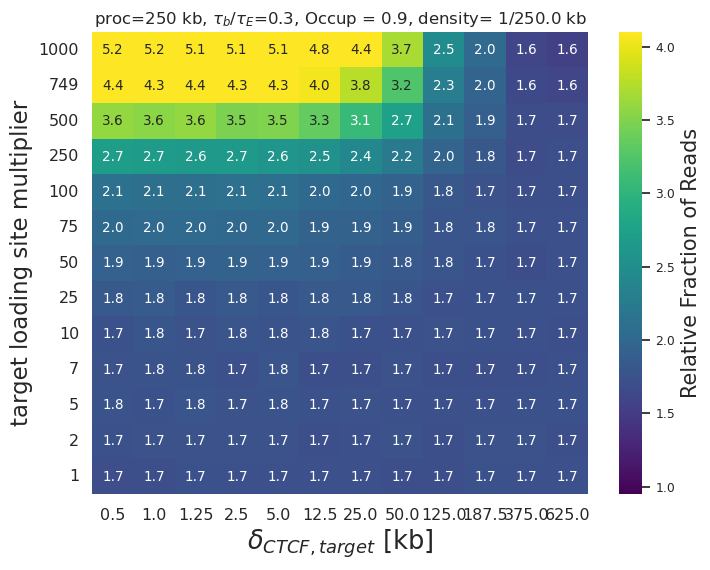

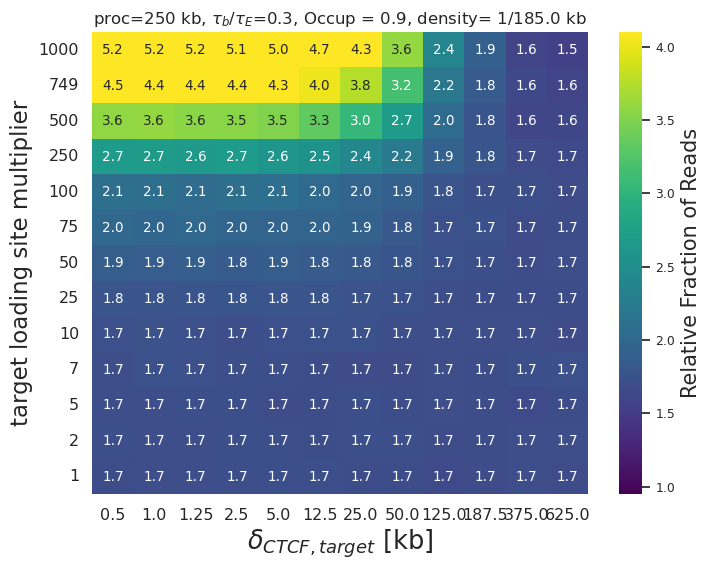

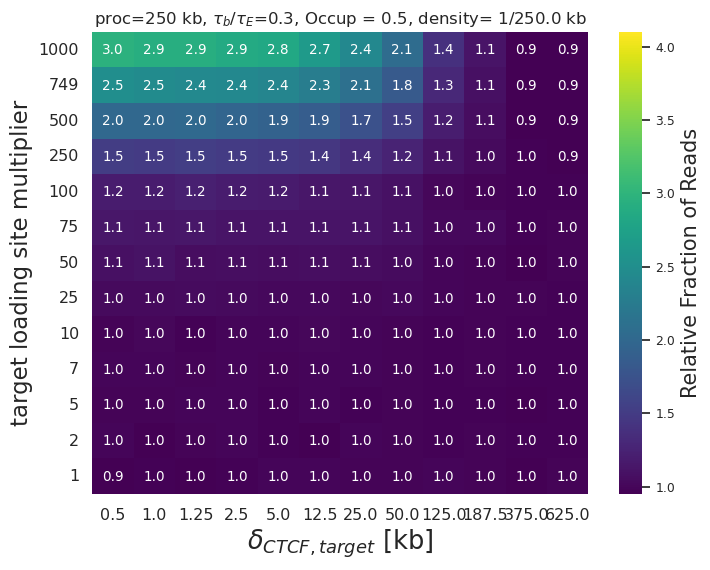

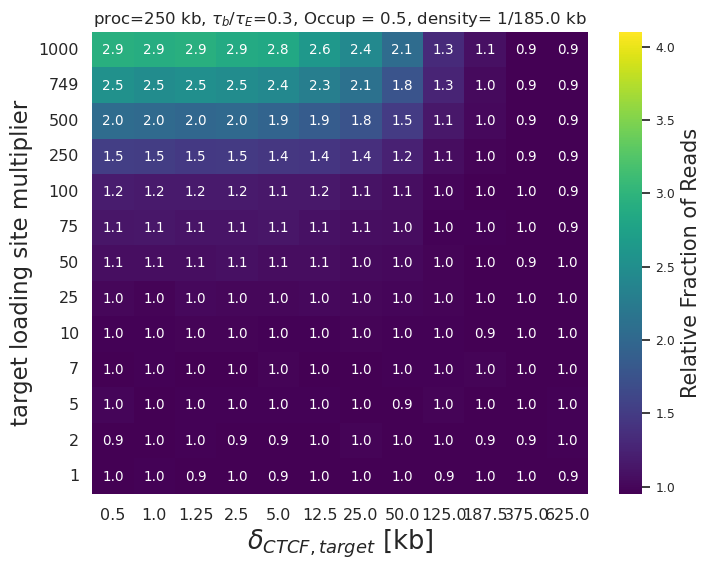

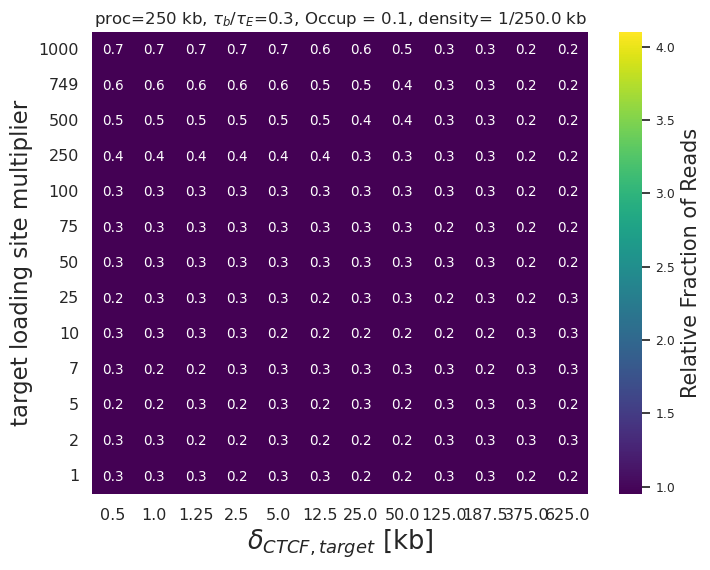

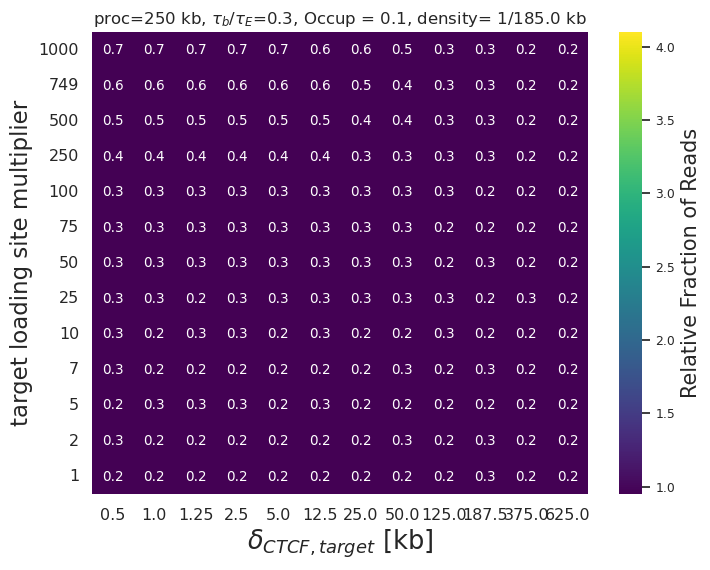

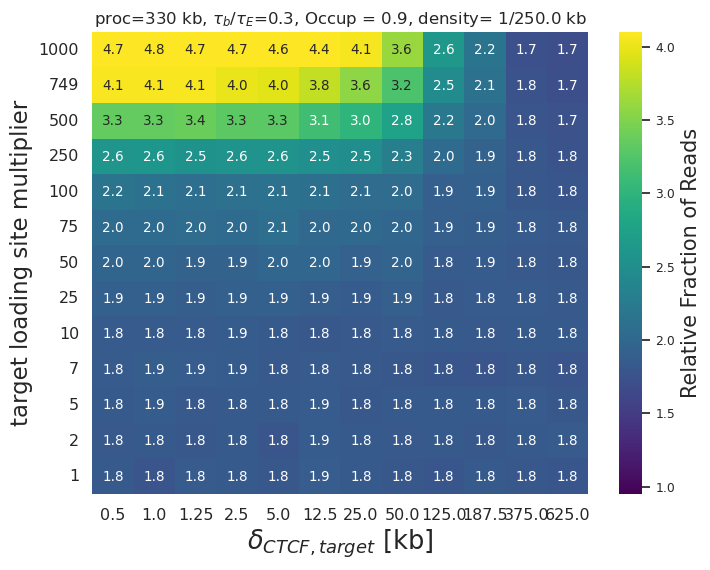

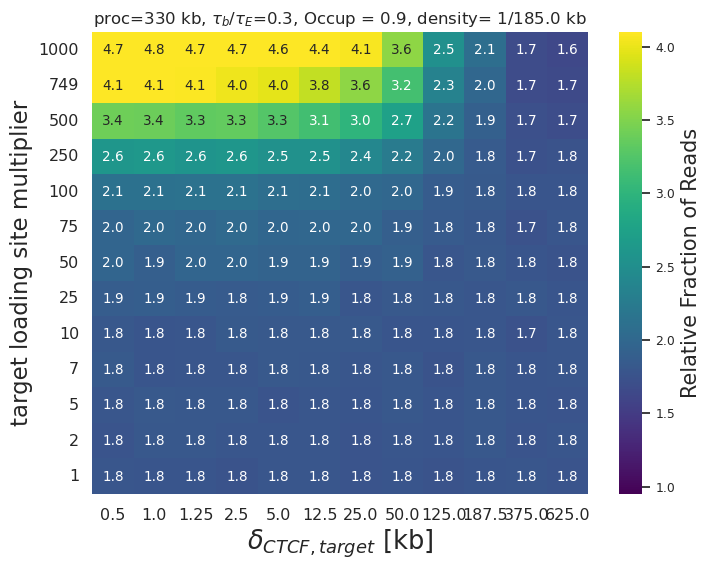

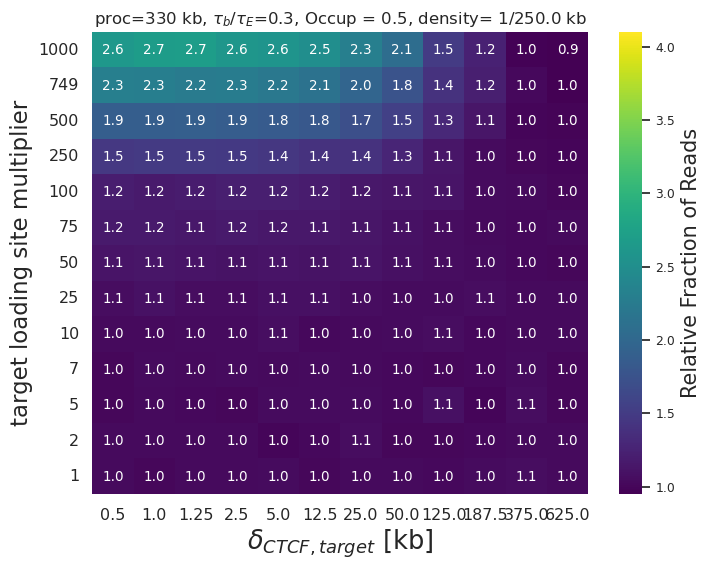

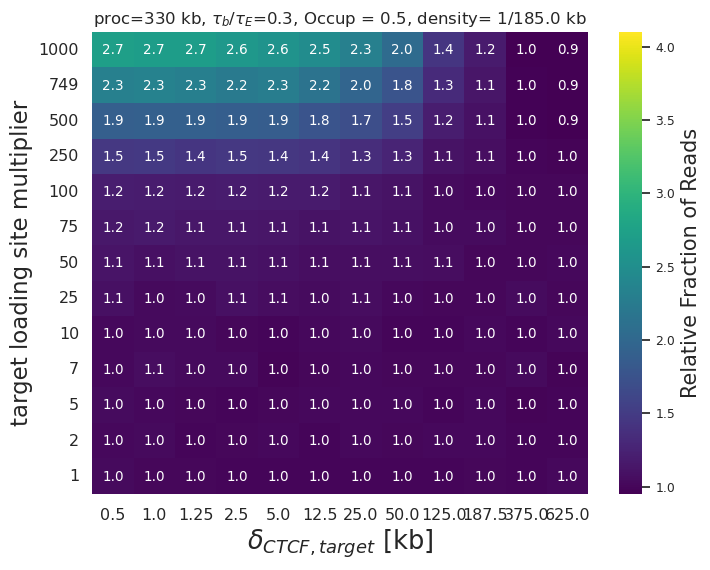

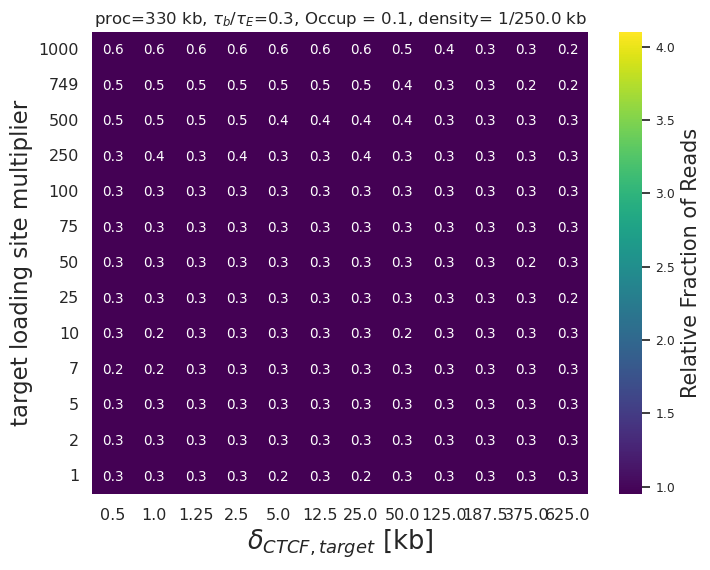

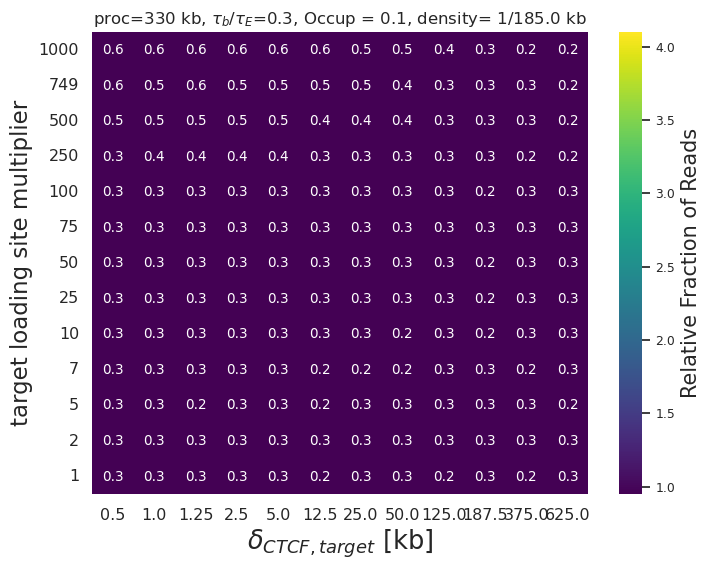

In [4]:
file = pd.read_csv('data/frip_target_respoints_w1_main_tau17_all_density_changing_chn.csv')

file = file.copy()  
file['birthp'] = (file['birth'] / ReferenceLoad).astype(int)
file['deltactcf'] = (file['deltactcf'] / 2) * LatticeCoversion  # factor of 2 per your note

unique_deltactcf = np.unique(file['deltactcf'])
clife = np.unique(file['clife'])[0]

sns.set(font_scale=0.81)  # set once

for life in np.unique(file['life']):
    for cof_val in np.unique(file['cof']):
        for sep_vals in [100, 74]:
            new_file = file[
                (file['life'] == life) &
                (file['sep'] == sep_vals) &
                (file['cof'] == cof_val)
            ].copy()

            new_file['frip'] = (new_file['frip'] / float(ref_frip)).round(3)
            new_file = new_file[['birthp', 'deltactcf', 'frip']]

            new_file_filtered = new_file.drop_duplicates(keep='first')

            dtaframe_grouped = new_file_filtered.groupby(
                ['birthp', 'deltactcf'], as_index=False
            ).mean(numeric_only=True)

            heatmap_data = dtaframe_grouped.pivot('birthp', 'deltactcf', 'frip')

            # Create the heatmap using seaborn
            plt.figure(figsize=(8, 6))
            im = sns.heatmap(
                heatmap_data,
                annot=True,
                cmap='viridis',
                fmt='.1f',                 # fixed format string
                vmin=0.95,
                vmax=4.1,
                cbar_kws={'label': 'Frip score'}
            )

            cbar = im.collections[0].colorbar
            cbar.set_label('Relative Fraction of Reads', fontsize=15)

            # Customize
            plt.xlabel(r'$\delta_{CTCF, target}$ [kb]', fontsize=18.5)
            plt.xticks(fontsize=11.5)
            plt.ylabel(r'target loading site multiplier', fontsize=16.5)
            plt.yticks(fontsize=11.5, rotation=0)
            plt.title(
                r'proc=%s kb, $\tau_b$/$\tau_E$=%s, Occup = %s, density= 1/%s kb'
                % (life * 5, np.round(clife / life, 1), np.round(clife / (clife + cof_val), 1), sep_vals * 2.5),
                fontsize=11.95
            )

            plt.gca().invert_yaxis()
            plt.savefig(
                'figs/pdf/fripsweep_for_target_life_%s_clife_%s_cof_%s_sep_%s_normalized_changing_n.pdf'
                % (life, clife, cof_val, sep_vals),
                transparent=True,
                bbox_inches='tight'
            )
            plt.show()

#### Based on normalizing per kb

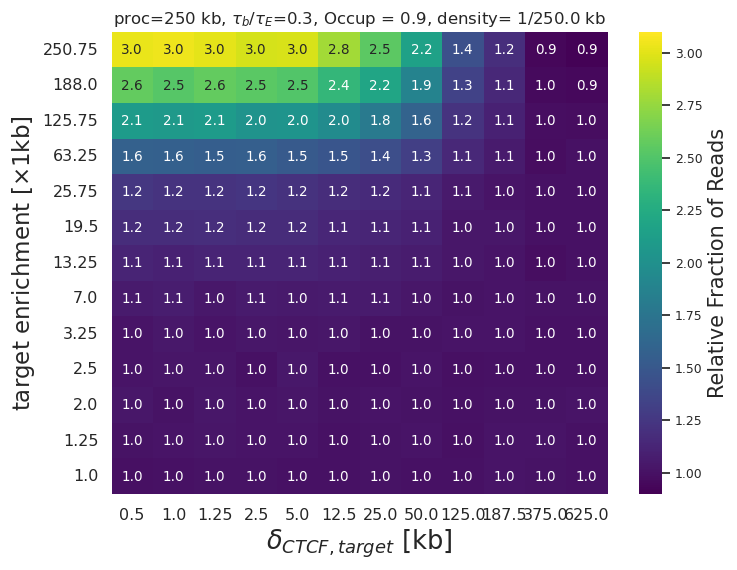

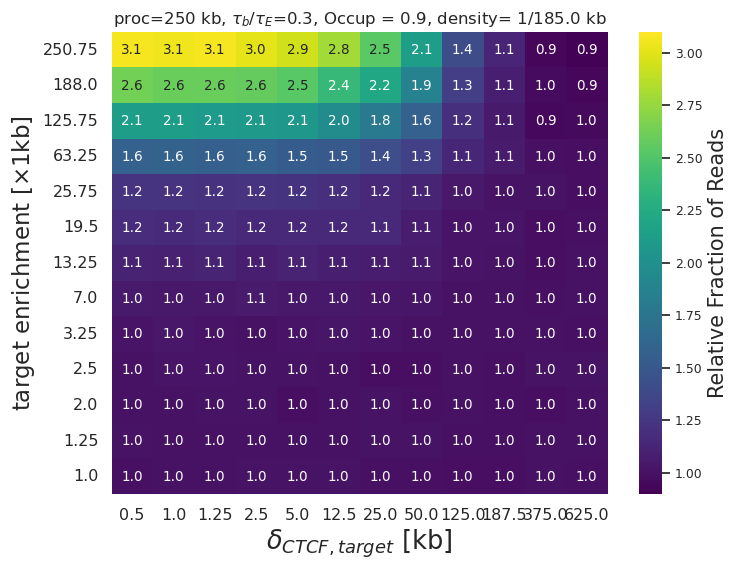

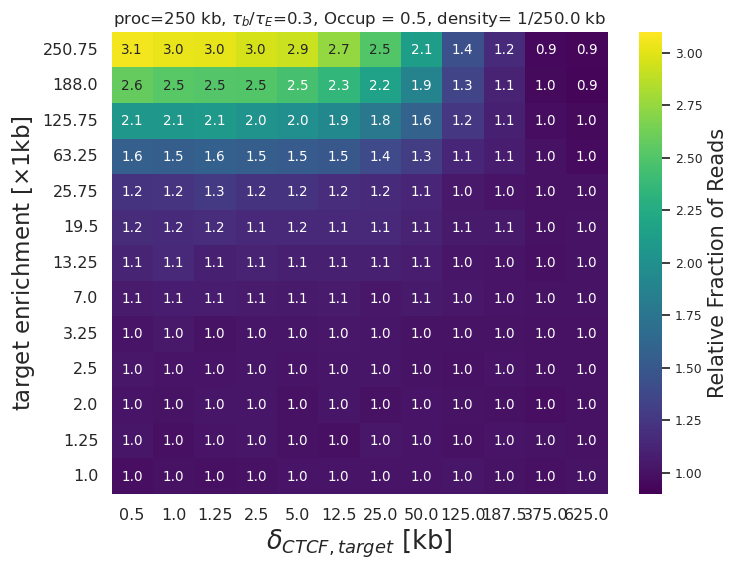

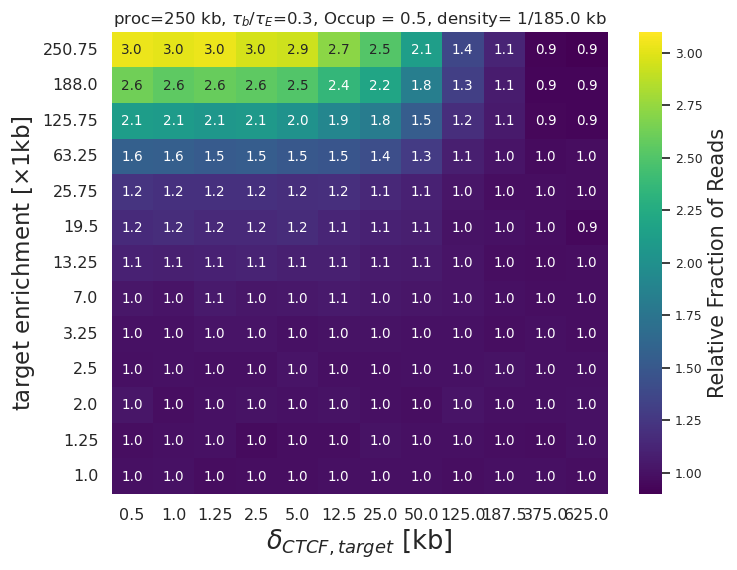

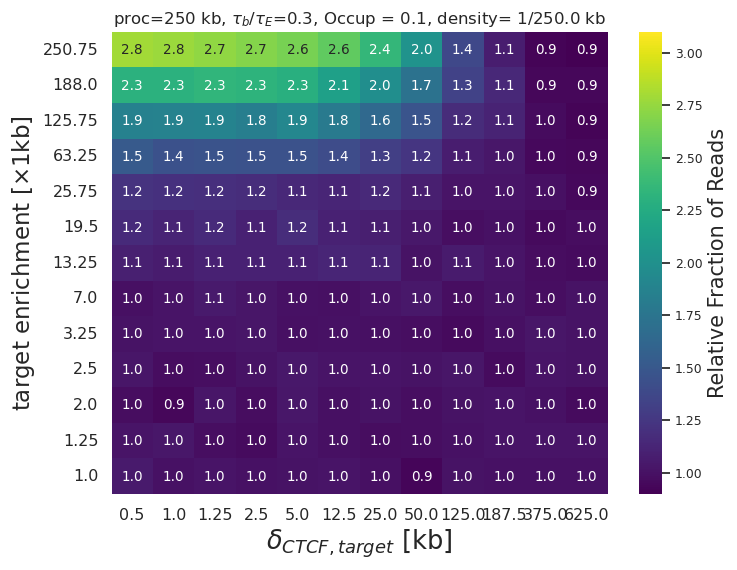

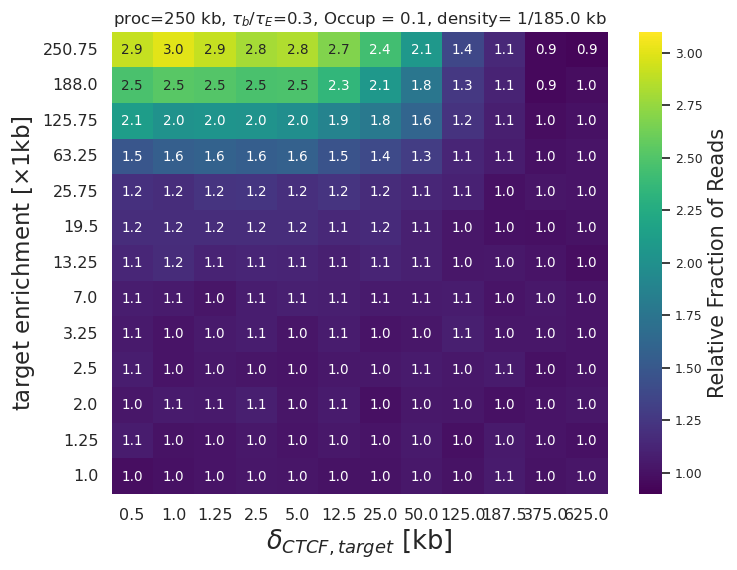

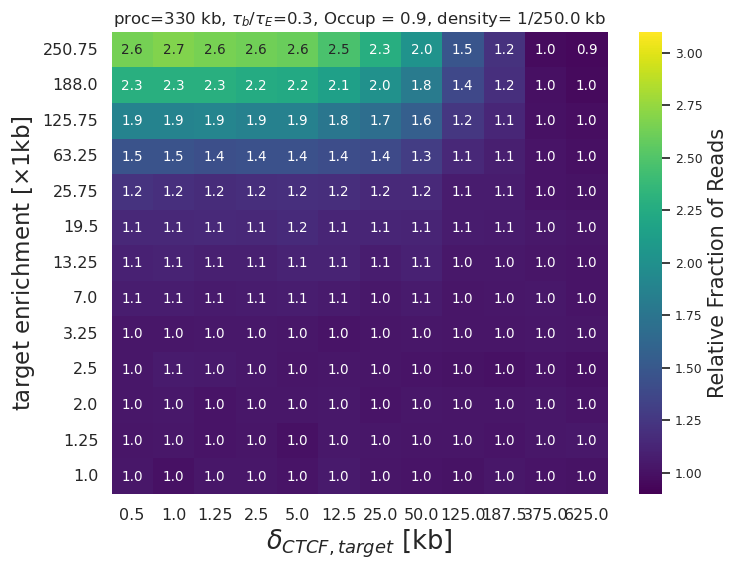

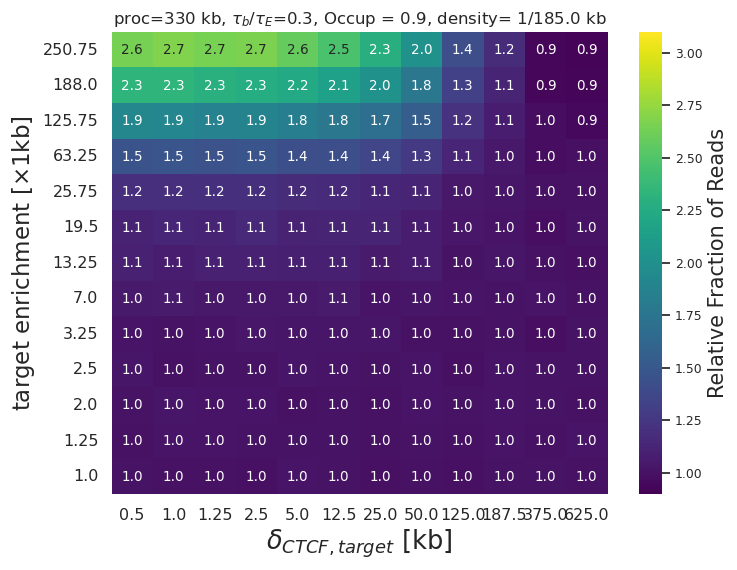

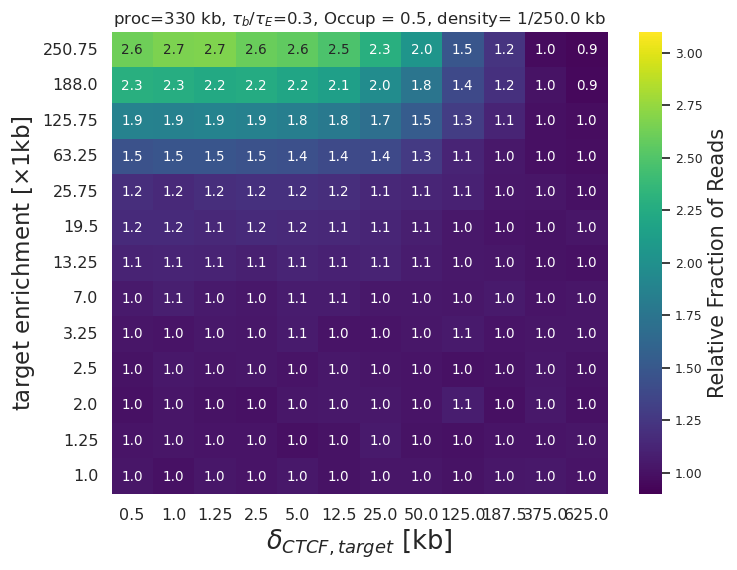

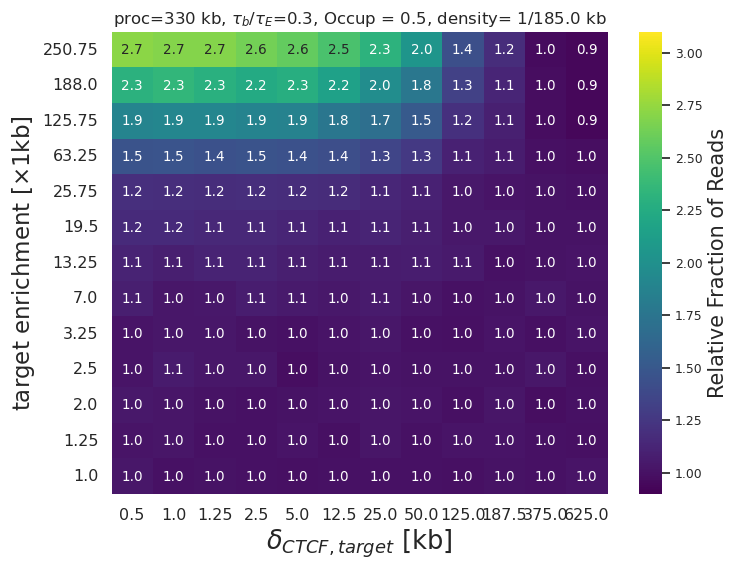

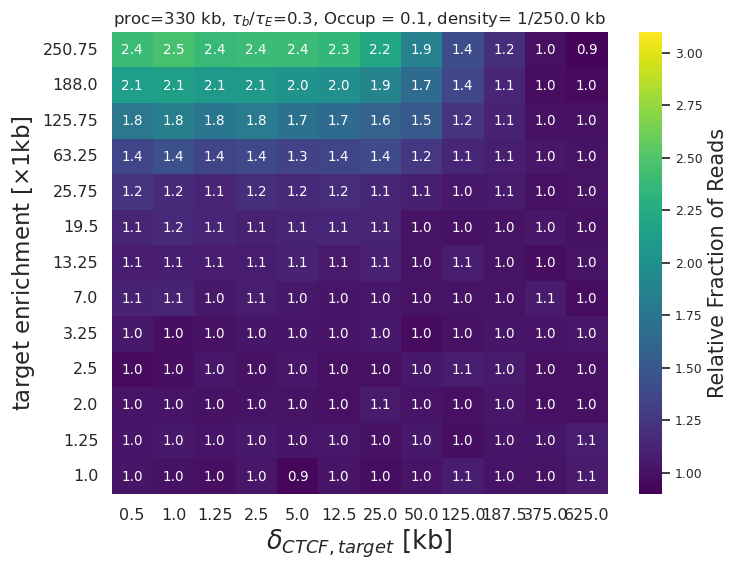

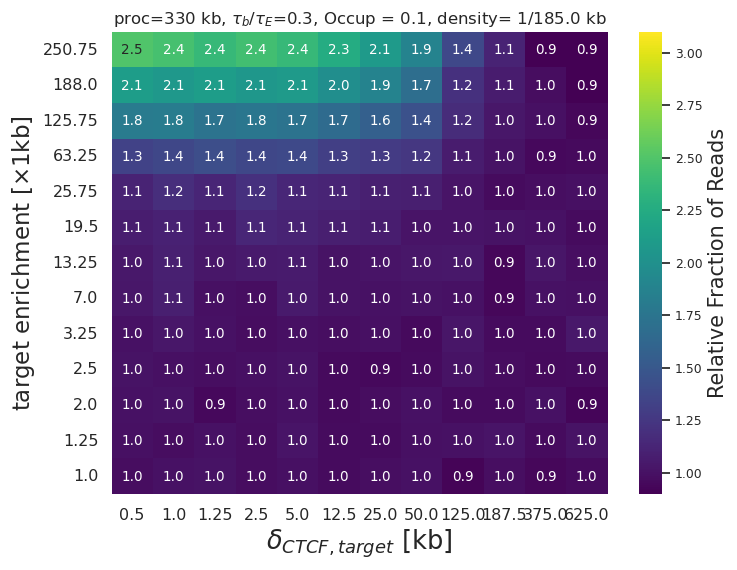

In [5]:
file = pd.read_csv('data/frip_target_respoints_w1_main_tau17_all_density_changing_chn.csv')

file = file.copy()
file['birthp'] = (file['birth'] / ReferenceLoad).astype(int)
file['deltactcf'] = (file['deltactcf'] / 2) * LatticeCoversion
unique_birth = np.unique(file['birth'])
file['per_k_mult'] = utils.per_k_multiplier(file['birthp'])
unique_deltactcf = np.unique(file['deltactcf'])
clife = np.unique(file['clife'])[0]

sns.set(font_scale=0.81)

for life in np.unique(file['life']):
    for cof_val in np.unique(file['cof']):
        for sep_vals in [100, 74]:

            # filter then copy to avoid SettingWithCopyWarning
            new_file = file[
                (file['life'] == life) &
                (file['sep'] == sep_vals) &
                (file['cof'] == cof_val)
            ].copy()

            # reference FRiP for normalization (ensure scalar)
            ref_frip = new_file.query('per_k_mult == 1 and deltactcf == 1')['frip'].iloc[0]

            new_file['frip'] = (new_file['frip'] / float(ref_frip))
            new_file['frip'] = new_file['frip'].round(3)
            new_file = new_file[['per_k_mult', 'deltactcf', 'frip']]

            new_file_filtered = new_file.drop_duplicates(keep='first')

            dtaframe_grouped = new_file_filtered.groupby(
                ['per_k_mult', 'deltactcf'], as_index=False
            ).mean(numeric_only=True)

            heatmap_data = dtaframe_grouped.pivot('per_k_mult', 'deltactcf', 'frip')

            # Create the heatmap using seaborn
            plt.figure(figsize=(8, 6))
            im = sns.heatmap(
                heatmap_data,
                annot=True,
                cmap='viridis',
                fmt='.1f',          # fixed format
                vmin=0.9,
                vmax=3.1,
                cbar_kws={'label': 'Frip score'}
            )
            cbar = im.collections[0].colorbar
            cbar.set_label('Relative Fraction of Reads', fontsize=15)

            # Customize 
            plt.xlabel(r'$\delta_{CTCF, target}$ [kb]', fontsize=18.5)
            plt.xticks(fontsize=11.5)
            plt.ylabel(r'target enrichment [$\times$1kb]', fontsize=16.5)
            plt.yticks(fontsize=11.5, rotation=0)
            plt.title(
                r'proc=%s kb, $\tau_b$/$\tau_E$=%s, Occup = %s, density= 1/%s kb'
                % (life * 5, np.round(clife / life, 1), np.round(clife / (clife + cof_val), 1), sep_vals * 2.5),
                fontsize=11.95
            )

            plt.gca().invert_yaxis()
            plt.savefig(
                'figs/pdf/fripsweep_for_target_life_%s_clife_%s_cof_%s_sep_%s_normalized_changing_n_per_k.png'
                % (life, clife, cof_val, sep_vals),
                transparent=True,
                bbox_inches='tight'
            )
            plt.show()

#### Visualizing contact maps from polymer simulations

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


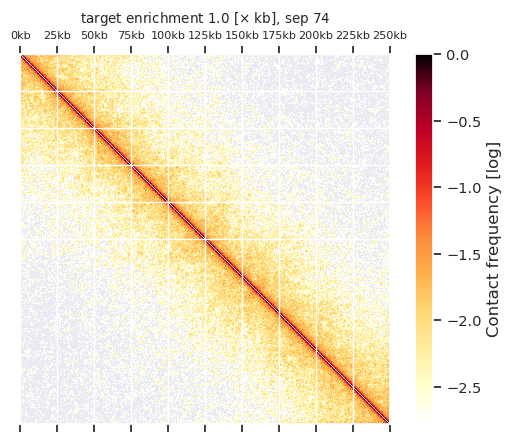

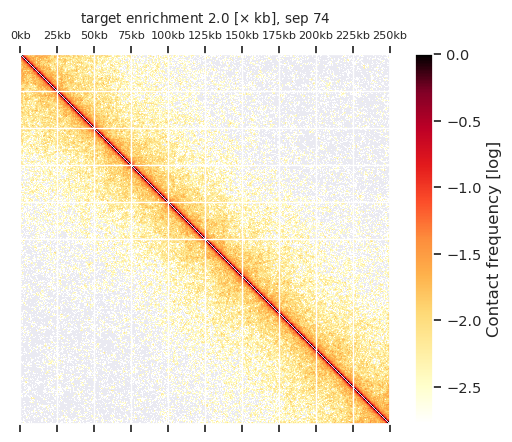

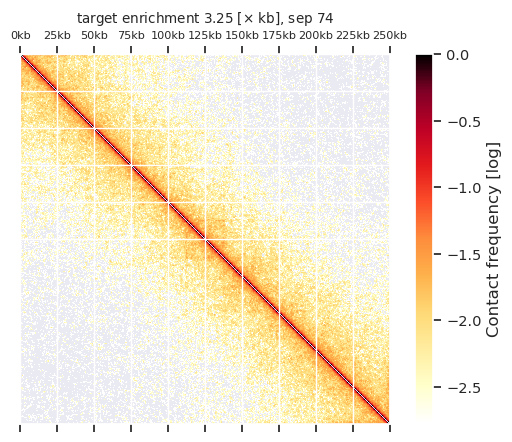

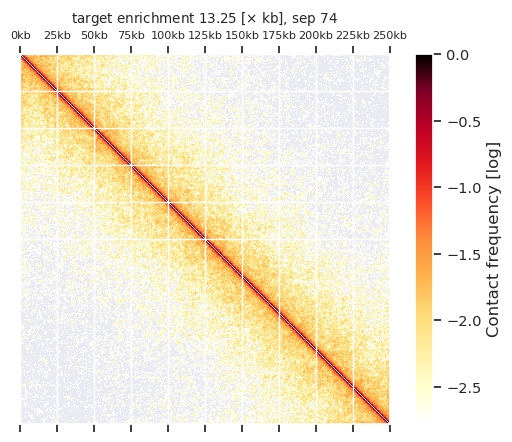

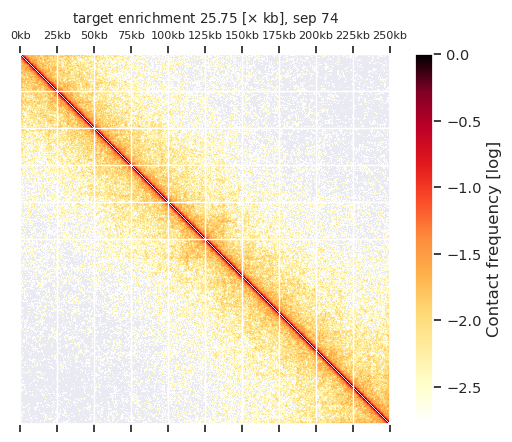

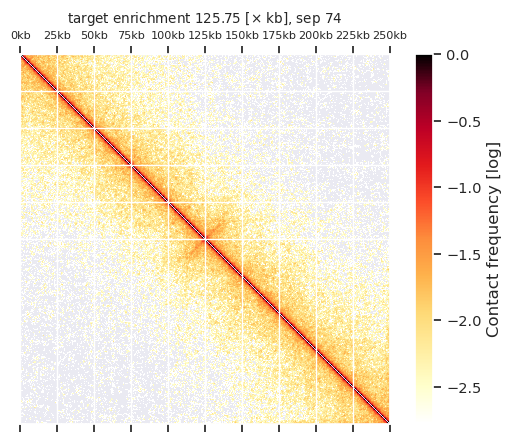

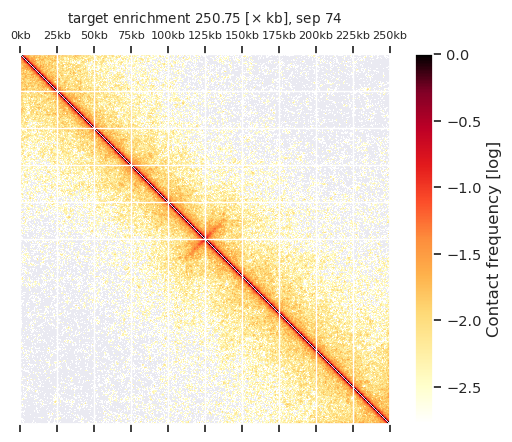

In [9]:
path_dict = {}

directory='/scratch1/rahmanin/target_loading_cohesin/target/sims_chn/'

for fname in glob.glob(directory+'folder*'):
    path_dict[fname.split('sims_chn/')[1][:]]= fname
path_dict = dict(sorted(path_dict.items()))

for name in list(path_dict)[:]:

    params=[ast.literal_eval(i) for i in name.split('folder_')[1].split('_')[1::2]]
    face, back, clife, cof, life, slife, birth, deltactcf, pause, sep, site, mon, rep, step, vel = params
    if deltactcf==1000:
        try:
            data=np.load('./maps/%s.npz' % name)
            mrc=data['arr_0']
            mrc  = mrc.astype(float)
            mrc /= np.median(np.diag(mrc,2))
            mat = np.log10(mrc)
            vmax = np.median(np.diag(mat,2))
            vmin = vmax - 2
            im=plt.matshow(mat[:,:], cmap='fall',fignum=False);
            cbar=plt.colorbar(im,label='Contact frequency [log]')
            cbar.set_label(label='Contact frequency [log]',fontsize=11.95)
            cbar.ax.tick_params(labelsize=10.5)
            plt.xticks([0,100,200,300,400,500, 600, 700, 800, 900, 1000],fontsize=8.1)
            plt.yticks([0,100,200,300,400,500],fontsize=8.1)
            plt.title('relative load prob %s'%500)
            plt.gca().set_xticklabels(['0kb', '25kb', '50kb','75kb','100kb', '125kb', '150kb', '175kb', '200kb', '225kb', '250kb'])
            #plt.gca().set_yticklabels(['0Mb', '0.25Mb', '0.5Mb','0.75Mb','1Mb', '1.25Mb'])#plt.gca().set_yticklabels([])
            plt.gca().set_yticklabels([])
            plt.title(r'target enrichment %s [$\times$ kb], sep %s'%(utils.per_k_multiplier(birth/0.0001), sep))
            plt.savefig('./figs/maps/maps_for_%s.png'%name,transparent=True)
            plt.show() 
        except Exception as e:
            pass

#### fountain/correlation score

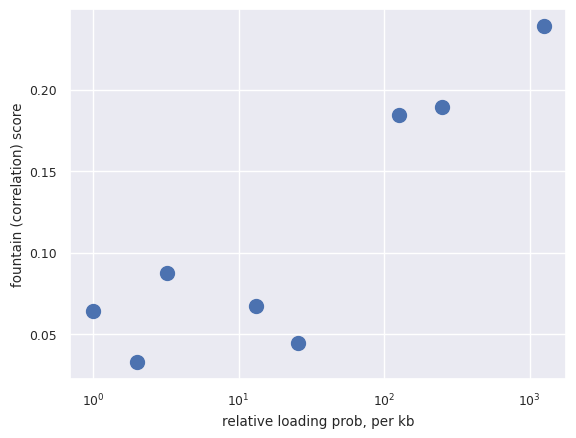

In [10]:
file = pd.read_csv('data/fountain.csv')

file['birthp']=utils.per_k_multiplier(file['birth']/0.0001)
new_file = file[file['deltactcf']==3000]
plt.scatter(new_file['birthp'],new_file['fountainscore'], s=100)
plt.ylabel('fountain (correlation) score')
plt.xlabel('relative loading prob, per kb')
plt.xscale('log')
plt.savefig('fountainscore.png')
plt.show()